# Något med poliser

https://openpolicing.stanford.edu/data/ 
Vermont - State patrol. Standardized stop data. 
Army clock.

Hypothesis: The later the hour, the more people of color get stopped.
One can argue about what is late and when does late become early? I focus on the hours when the majority of people are asleep (and it's still dark outside, maybe, depending on when the sun rises). 

In [127]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np
import sqlite3 as sql
import re
import datetime
from wordcloud import STOPWORDS
from wordcloud import WordCloud

In [7]:
vermont_all = pd.read_csv('https://raw.githubusercontent.com/elliphantonator/su-mt4007/refs/heads/main/Project/Vermont.csv')
vermont_all.tail()

,raw_row_number,date,time,location,lat,lng,subject_age,subject_race,subject_sex,officer_id_hash,...,outcome,contraband_found,search_conducted,search_basis,raw_stop_city,raw_stop_reason_description,raw_stop_search_description,raw_stop_outcome_description,raw_driver_gender,raw_driver_race
283280,283281,2015-07-22,16:28:00,"I89: Northbound mm 72, Barton, VT, 05822",44.165030,-72.578761,21.0,white,male,199dea4ce5,...,citation,NaN,False,NaN,Barton,Moving Violation,No Search Conducted,Ticket / VCVC Issued,M,W
283281,283282,2015-08-24,16:35:00,"US Route 7, Dorset, VT, 05251",43.259858,-73.007935,42.0,asian/pacific islander,NaN,b7e700f7a7,...,warning,NaN,False,NaN,Dorset,Moving Violation,No Search Conducted,Written Warning Issued,NaN,A
283282,283283,2015-10-13,12:03:00,"US Route 7, Middlebury, VT, 05753",44.015370,-73.166980,48.0,white,male,b7e700f7a7,...,warning,NaN,False,NaN,Middlebury,Moving Violation,No Search Conducted,Written Warning Issued,M,W
283283,283284,2015-10-13,12:03:00,"US Route 7, Middlebury, VT, 05753",44.015370,-73.166980,48.0,white,male,b7e700f7a7,...,warning,NaN,False,NaN,Middlebury,Moving Violation,No Search Conducted,Written Warning Issued,M,W
283284,283285,2015-12-08,09:02:00,"I89; mm45, Williamstown, VT, 05679",44.114380,-72.605058,18.0,white,male,199dea4ce5,...,citation,NaN,False,NaN,Williamstown,Moving Violation,No Search Conducted,Ticket / VCVC Issued,M,W


subject_race
poc          498.291667
white      11010.833333
poc %          0.047464
white %        0.952536
dtype: float64

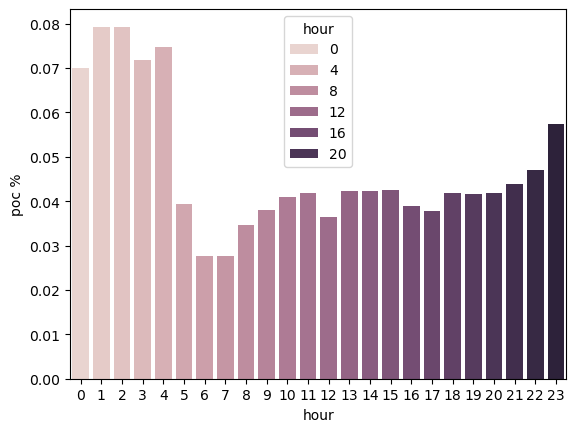

In [8]:
# Convert 'time' to datetime and extract the hour
vermont_all['hour'] = pd.to_datetime(vermont_all['time'], format = '%H:%M:%S').dt.hour

# Create a subset of relevant columns and add a counter column
relevant_vermont = vermont_all[['hour', 'subject_age', 'subject_race', 'subject_sex']].copy()
relevant_vermont['counter'] = 1 

# Clean the data: Replace 'unknown' with NaN, drop rows with NaN, and classify non-white races as 'poc'
relevant_vermont = relevant_vermont.replace('unknown', np.nan).dropna() 
relevant_vermont = relevant_vermont.replace(['asian/pacific islander', 'black', 'hispanic', 'other'], 'poc')

# Group by hour and subject_race, summing counters
relevant_vermont = relevant_vermont[['hour', 'subject_race', 'counter']].groupby(['hour', 'subject_race']).sum().reset_index()

# Pivot to get race as columns
pivoted = relevant_vermont.pivot(columns='subject_race', index='hour', values='counter')

# Adding %-columns
pivoted['poc %'] = pivoted['poc']/(pivoted['poc'] + pivoted['white'])
pivoted['white %'] = pivoted['white']/(pivoted['poc'] + pivoted['white'])

sns.barplot(x = 'hour', y = 'poc %', data = pivoted, hue = 'hour')

pivoted.mean()